# Continuous Variable Neural Net Simulation

This notebook is based on [this paper](https://arxiv.org/abs/1806.06871), and generalizes some of its results to two dimensions. The [paper's source code](https://github.com/XanaduAI/quantum-neural-networks/blob/master/function_fitting/function_fitting.py) serves as the basis, with modifications to improve presentability and to generalize.

Some of the code is organized into large blocks defining important functions so that plots and comparisions of the results can be organized together at the end of the notebook. They do not need to be read in order, and in fact may just as well be read in reverse to provide context, but regardless of their order comments within the code block will be just as helpful as text like this. Comments from the original authors have been stripped out (with the exception of docstrings) for consistency in style and vocabulary, but they can be found in the original source code.

To read in reverse, simply start with [Single-Qumode-Model](#Single-Qumode-Model) and [Double-Qumode-Model](#Double-Qumode-Model)

The first section of this notebook, [Reproducing-Results-in-One-Dimension](#Reproducing-Results-in-One-Dimension) follows the structure of the paper and includes much of the original code, modified and simplified for presentation here.

The second section of this notebook, [Generalizing-to-Two-Dimensions](#Generalizing-to-Two-Dimensions) does as the title implies and implements a neural net with two qumodes. This accomplishes two goals:

1) It gives a sense of the increased computational complexity of simulatinf even a relatively small system

2) It allows for a reproduction of the full neural net described in the paper, including a 2-qumode gate called a beamsplitter.

The first step is setting up the imports. `strawberryfields` is developed by the paper's authors and serves as the simulator of the quantum computer, `tensorflow` provides machine learning capabilities such as gradient descent, and `matplotlib` is used for visualizations

In [1]:
import os
import time

import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import cm
import mpl_toolkits.mplot3d 

import tensorflow as tf

import strawberryfields as sf
from strawberryfields.ops import *

import sys

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:461: FutureWarning: Passing (type, 1) or 

The follwing are hyperparameters for the simulation. They are identical to the source paper with the exception of `reps`, the number of iterations in the training loop, which has been reduced by a factor of 10 for simplicity.

In [2]:
# Maximum dimension of the Fock basis
cutoff = 10
# Bounding on the visualization
xmax = 1
# Batch size of the data. In this case the training and test data have the same number of samples
batch_size = 50
# Number of layers in the neural network.
depth = 6

# Some bounds for the quantum gates under simulation.
disp_clip = 1000
sq_clip = 50
kerr_clip = 50

# Iterations of training
reps = 200

# Reproducing Results in One Dimension

This section reproduces the results of the original paper in one dimension, with simplifications and added comments

The code below represents the ideal function that the model hopes to learn.

In [3]:
def f1(x):
    return np.sin(1.0 * x * np.pi)

The code below sets up the simulation engine with a single qumode. The engine includes the circuit definition that composes the neural network. The theoretical basis and a more complete description of the gates are both described in [the original paper](https://arxiv.org/abs/1806.06871) as well as the accompanying written report, but in general each layer represents both a linear and nonlinear function applied to the input, with the parameters of both configurable by an optimizer. The optimizer experiments with updates that improve the quality of the model, as measured by the loss function. In this case the loss function simply measures the distance between what the model outputs and the true sine function above.

In [4]:
def prepare_engine_1():
    global cost, loss, mean_x, error_size, var, state_norm, input_data, output_data
    
    # Standard deviation of the distribution producing the random initialization
    sdev = 0.05

    # These are the parameters to be optimized. Each corresponds to one of the gates in the neural net
    # They are organized by time. E.g., all displacement gates are configured by d_r and d_phi
    with tf.name_scope('variables'):
        d_r = tf.Variable(tf.random_normal(shape=[depth], stddev=sdev))
        d_phi = tf.Variable(tf.random_normal(shape=[depth], stddev=sdev))
        r1 = tf.Variable(tf.random_normal(shape=[depth], stddev=sdev))
        sq_r = tf.Variable(tf.random_normal(shape=[depth], stddev=sdev))
        sq_phi = tf.Variable(tf.random_normal(shape=[depth], stddev=sdev))
        r2 = tf.Variable(tf.random_normal(shape=[depth], stddev=sdev))
        kappa1 = tf.Variable(tf.random_normal(shape=[depth], stddev=sdev))
    
    # Initialize Strawberry Fields with a single qumode
    eng, q = sf.Engine(1)
    
    def layer(i):
        """This function generates the ith layer of the quantum neural network.

        Note: it must be executed within a Strawberry Fields engine context.

        Args:
            i (int): the layer number.
        """
        with tf.name_scope('layer_{}'.format(i)):
            # Displacement
            Dgate(tf.clip_by_value(d_r[i], -disp_clip, disp_clip), d_phi[i]) | q[0]
            # Rotation
            # his is technically a component of an interfermoter including a beamsplitter, but that is a 2-qumode gate
            Rgate(r1[i]) | q[0]
            # Squeezing
            Sgate(tf.clip_by_value(sq_r[i], -sq_clip, sq_clip), sq_phi[i]) | q[0]
            # Second rotatin with the same caveat as above
            Rgate(r2[i]) | q[0]
            # The "nonlinearity", in this case a Kerr Gate
            Kgate(tf.clip_by_value(kappa1[i], -kerr_clip, kerr_clip)) | q[0]

    # This variable holds the inputs to the model
    input_data = tf.placeholder(tf.float32, shape=[batch_size])

    # This is the circuit definition. The code inside the block is technically in the Blackbird language
    # Blackbird is a Strawberry Fields construct, and more information can be found in the paper describing it
    # https://arxiv.org/abs/1804.03159
    with eng:
        # The input data are encoded as a simple displacement of the qumode.
        Dgate(input_data) | q[0]

        # The neural net is formed by applying the layers in sequence
        for k in range(depth):
            layer(k)

    # This runs the simulation defined above
    state = eng.run('tf', cutoff_dim=cutoff, eval=False, batch_size=batch_size)

    # This code measures the output, specifically quad_expectation
    # In this case the mean is taken to be the prediction and the standard deviation the confidence
    ket = state.ket()
    mean_x, svd_x = state.quad_expectation(0)
    error_size = tf.sqrt(svd_x)

    # The loss function is taken to be a simple mean squared error
    output_data = tf.placeholder(tf.float32, shape=[batch_size])
    loss = tf.reduce_mean(tf.abs(mean_x - output_data) ** 2)
    var = tf.reduce_mean(error_size)

    # This code makes the loss available to the optimizer.
    state_norm = tf.abs(tf.reduce_mean(state.trace()))
    # The original code included some inactive regularization, which was removed here for simplification.
    cost = loss
    tf.summary.scalar('cost', cost)

With the simulation set up, it is now possible to train and assess the model. The code below is a utility function to visualize the data to make the model's progress more clear.

In [5]:
def visualize_state(session, save_state = False):
    
    # Take predictions from the current state of the model
    predictions = session.run(mean_x, feed_dict={input_data: test_data})

    if save_state:
        np.save('sine_test_predictions', test_predictions)
        print("Elapsed time is {} seconds".format(np.round(end_time - start_time)))

    # Get an arbitrary set of inputs to make a nice curve
    x = np.linspace(-xmax, xmax, 200)

    # Set up fonts
    rcParams['font.family'] = 'serif'
    rcParams['font.sans-serif'] = ['Computer Modern Roman']

    # Turn interactive plotting off to avoid unexpected empty plots
    plt.ioff()
    fig, ax = plt.subplots(1,1)

    # Plot the ideal
    ideal = ax.plot(x, f1(x), color='#3f9b0b', zorder=1, linewidth=2, label="Ideal")

    # Plot the training data, which deviate from the ideal randomly (and intentionaly)
    training = ax.scatter(train_data, data_y, color='#fb2943', marker='o', zorder=2, s=75, label="Training Data")

    # Plot the model's current predictions
    model = ax.scatter(test_data, predictions, color='#0165fc', marker='x', zorder=3, s=75, label="Model")

    ax.set_xlabel('Input', fontsize=18)
    ax.set_ylabel('Output', fontsize=18)
    ax.tick_params(axis='both', which='minor', labelsize=16)
    
    #ax.legend(handles=[ideal, training, model])
    ax.legend()
    
    plt.show()

## Generalizing to Two Dimensions

The code below generalizes the above result to two dimensions, which demonstrates both the increase in computational complexity, and the complete description of the neural net from the original paper, including beamsplitters. Since the code is largely similar, comments are left out for redundant code in order to focus on that which contributes to the generalization.

The cell below defines the ideal function the model hopes to learn. Similar to the above, it is kept simple for this demonstration.

In [6]:
def f2(x, y):
    return np.sin(x * np.pi) + np.cos(y * np.pi)

The code below is similar to `prepare_engine_1` above, but adds an extra dimension to the inputs and the existing gates, adds beamsplitters to each layer, and performs addition on the output to combine the results into one.

In [7]:
def prepare_engine_2():
    global cost, loss, mean_x, error_size, var, state_norm, input_data, output_data
    
    sdev = 0.05

    with tf.name_scope('variables'):
        d_r = tf.Variable(tf.random_normal(shape=[depth, 2], stddev=sdev))
        d_phi = tf.Variable(tf.random_normal(shape=[depth, 2], stddev=sdev))
        r1 = tf.Variable(tf.random_normal(shape=[depth, 2], stddev=sdev))
        # NB that beamsplitters are 2-qumode gates and therefore do not need duplication
        bs1 = tf.Variable(tf.random_normal(shape=[depth], stddev=sdev))
        sq_r = tf.Variable(tf.random_normal(shape=[depth, 2], stddev=sdev))
        sq_phi = tf.Variable(tf.random_normal(shape=[depth, 2], stddev=sdev))
        r2 = tf.Variable(tf.random_normal(shape=[depth, 2], stddev=sdev))
        bs2 = tf.Variable(tf.random_normal(shape=[depth], stddev=sdev))
        kappa1 = tf.Variable(tf.random_normal(shape=[depth, 2], stddev=sdev))
    
    # NB the engine is initialized with the extra qumode
    eng, q = sf.Engine(2)
    
    def layer(i):
        with tf.name_scope('layer_{}'.format(i)):
            Dgate(tf.clip_by_value(d_r[i, 0], -disp_clip, disp_clip), d_phi[i, 0]) | q[0]
            Dgate(tf.clip_by_value(d_r[i, 1], -disp_clip, disp_clip), d_phi[i, 1]) | q[1]

            Rgate(r1[i, 0]) | q[0]
            Rgate(r1[i, 1]) | q[1]
        
            # Here the beamsplitter is applied to both qumodes
            BSgate(bs1[i]) | (q[0], q[1])

            Sgate(tf.clip_by_value(sq_r[i, 0], -sq_clip, sq_clip), sq_phi[i, 0]) | q[0]
            Sgate(tf.clip_by_value(sq_r[i, 1], -sq_clip, sq_clip), sq_phi[i, 1]) | q[1]

            Rgate(r2[i, 0]) | q[0]
            Rgate(r2[i, 1]) | q[1]

            BSgate(bs2[i]) | (q[0], q[1])

            Kgate(tf.clip_by_value(kappa1[i, 0], -kerr_clip, kerr_clip)) | q[0]
            Kgate(tf.clip_by_value(kappa1[i, 1], -kerr_clip, kerr_clip)) | q[1]

    # NB that the input has also increased in dimensionality
    input_data = tf.placeholder(tf.float32, shape=[batch_size, 2])


    with eng:

        Dgate(input_data[:, 0]) | q[0]
        Dgate(input_data[:, 1]) | q[1]

        for k in range(depth):
            layer(k)

    state = eng.run('tf', cutoff_dim=cutoff, eval=False, batch_size=batch_size)

    ket = state.ket()
    # Noting input as z and y and output as x is inconsistent with the plots, but simplifies the code
    mean_z, svd_z = state.quad_expectation(0)
    mean_y, svd_y = state.quad_expectation(1)
    # By simply summing the two we allow one dimension to learn sine and the other cosine
    mean_x = mean_z + mean_y
    error_size = tf.sqrt(svd_z) + tf.sqrt(svd_y)

    output_data = tf.placeholder(tf.float32, shape=[batch_size])
    
    loss = tf.reduce_mean(tf.abs(mean_z - output_data) ** 2)
    var = tf.reduce_mean(error_size)

    state_norm = tf.abs(tf.reduce_mean(state.trace()))
    cost = loss
    tf.summary.scalar('cost', cost)

As before, the code below is similar to `visualize_state` and accomplishes the same goal, but with the added complexity of 3-dimensional plots

In [8]:
def visualize_state_3d(session, save_state = False):
    
    # As above, keep the x notation to be consistent in code, but plot this on the z-axis
    predictions = session.run(mean_x, feed_dict={input_data: test_data})

    if save_state:
        np.save('sine_test_predictions', test_predictions)
        print("Elapsed time is {} seconds".format(np.round(end_time - start_time)))

    # set plotting options
    rcParams['font.family'] = 'serif'
    rcParams['font.sans-serif'] = ['Computer Modern Roman']

    plt.ioff()
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

    # Borrowing from https://matplotlib.org/stable/gallery/mplot3d/surface3d.html
    X = np.arange(-1, 1, 0.1)
    Y = np.arange(-1, 1, 0.1)
    X, Y = np.meshgrid(X, Y)
    Z = f2(X, Y)

    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap=cm.Greys,
                           linewidth=0, antialiased=False)

    # plot the training data, in red
    ax.scatter3D(train_data[:,0],train_data[:,1], data_y,
                 color='#fb2943', marker='o', zorder=2, s=75, label="Training Data")

    # plot the test predictions, in blue
    ax.scatter(test_data[:, 0], test_data[:, 1], predictions,
               color='#0165fc', marker='x', zorder=3, s=75, label="Model")
    ax.set_xlabel('Input X', fontsize=18)
    ax.set_ylabel('Input Y', fontsize=18)
    ax.set_zlabel('Output', fontsize=18)
    ax.tick_params(axis='both', which='minor', labelsize=16)

    ax.legend()
    
    plt.show()

# The Training Loop

The code below defines the loop for training the model. This notebook uses the Adam optimizer from Tensorflow to be consistent with the source material. It performs the number of training iterations specificed by `reps`, and produces a visualization during intermediate steps to help give an intuitive sense of progress beyond simply following the loss function.

A key difference between this demo and the original paper is the increased learning rate. The learning rate is a parameter to Adam which controls how aggressively parameters are updated in response to errors. This demo uses higher learning rates to shorten simulation times, in particular for the 2-qumode simulation, which is very computationally demanding.

In [9]:
# Since this demo uses fewer iterations than the paper, it also uses a higher learning rate
def run_training_loop(loss_mod=100, viz_mod=100, use3d=False, learning_rate=0.002):
    global session, train_data, data_y
    
    # Adam is an optimizer, which is simply an algorithm that adjusts the model's parameters
    # It adjusts them strategically with the hope of minimizing the loss function, which tracks performance
    # More about Adam can be found here https://arxiv.org/abs/1412.6980
    optimiser = tf.train.AdamOptimizer(learning_rate=learning_rate)
    min_op = optimiser.minimize(cost)

    # Tensorflow uses a Session to keep track of all the variables defined in the functions above
    # Importantly, this code uses a legacy version of this class
    # https://www.tensorflow.org/api_docs/python/tf/compat/v1/Session
    # This is to be consistent with the implementation in the paper
    session = tf.Session()
    session.run(tf.global_variables_initializer())

    loss_vals = []
    error_vals = []

    # Keep track of time to help approximate computational complexity
    start_time = time.time()

    for i in range(reps+1):

        # This is the core of the training loop. It hands things over to Adam to adjust the parameters
        loss_, predictions, errors, mean_error, ket_norm, _ = session.run(
            [loss, mean_x, error_size, var, state_norm, min_op],
            feed_dict={input_data: train_data, output_data: data_y})

        loss_vals.append(loss_)
        error_vals.append(mean_error)

        # Logging to track progress
        if i % loss_mod == 0:
            print('Step: {} Loss: {}'.format(i, loss_))
            print("Elapsed time is {} seconds".format(np.round(time.time() - start_time)))
        if i % viz_mod == 0:
            if use3d:
                visualize_state_3d(session)
            else:
                visualize_state(session)

    end_time = time.time()
    return end_time - start_time

# Single Qumode Model

This section monitors the training of a single qumode model on a single-variable function, the sine curve.

Step: 0 Loss: 0.7025519609451294
Elapsed time is 1.0 seconds


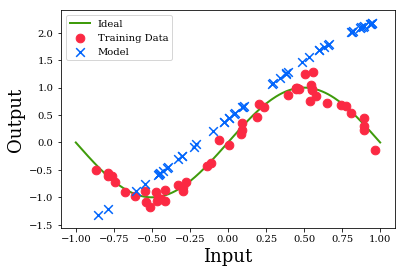

Step: 50 Loss: 0.0766715407371521
Elapsed time is 5.0 seconds
Step: 100 Loss: 0.05049150437116623
Elapsed time is 7.0 seconds


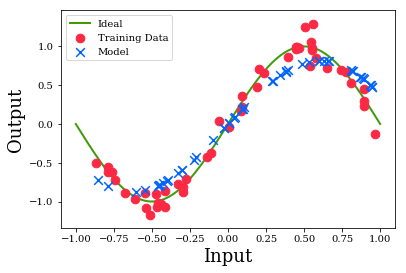

Step: 150 Loss: 0.033697858452796936
Elapsed time is 10.0 seconds
Step: 200 Loss: 0.021705692633986473
Elapsed time is 13.0 seconds


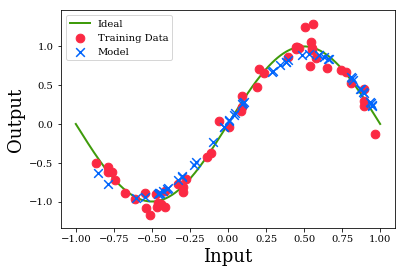

In [10]:
train_data = np.load('sine_train_data.npy')
test_data = np.load('sine_test_data.npy')
data_y = np.load('sine_outputs.npy')

prepare_engine_1()
single_time = run_training_loop(50, 100)

# Double Qumode Model

In this case the learning rate is increased based on previous experiments, which showed that the model was much slower to converge in 2 qumodes than one. The training data and model predictions are indicated using the same symbols as above, with the surface representing the ideal case.

Step: 0 Loss: 0.9066413044929504
Elapsed time is 6.0 seconds


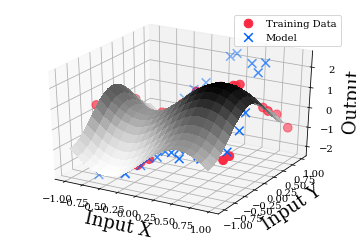

Step: 50 Loss: 0.04491659626364708
Elapsed time is 154.0 seconds
Step: 100 Loss: 0.015318240970373154
Elapsed time is 299.0 seconds


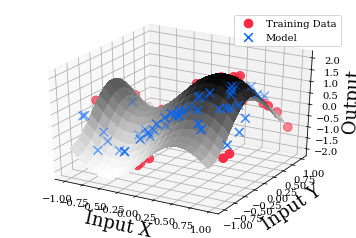

Step: 150 Loss: 0.011991455219686031
Elapsed time is 445.0 seconds
Step: 200 Loss: 0.01029140129685402
Elapsed time is 590.0 seconds


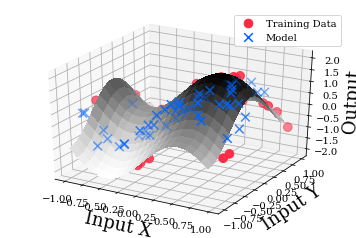

In [11]:
train_data = np.load('sine_2d_train_input.npy')
test_data = np.load('sine_2d_test_input.npy')
data_y = np.load('sine_2d_train_output.npy')

prepare_engine_2()
double_time = run_training_loop(50, 100, True, learning_rate=0.01)

# Time Comparison

These were measured on a dedicated AWS t3.2xlarge, run inside a Docker image.

The significant difference is noteworthy, and demonstrates the exponential complexity of simulating quantum systems. In fact, the 2-qumode quickly becomes intractable on machines smaller than t3.2xlarge (which allows for 8-fold parallelization), and even on such a large machine the number of iterations had to be reduced by a factor of 10 from the original paper to allow for timely iteration.

In [12]:
print("Time for one qumode is {} seconds".format(np.round(single_time)))
print("Time for two qumodes is {} seconds".format(np.round(double_time)))

Time for one qumode is 13.0 seconds
Time for two qumodes is 592.0 seconds
